In [8]:
## general
import numpy as np
import datetime
import joblib
import copy
import xarray as xr
import os
import sys
import datetime as dt
import matplotlib as mpl
import math

## statistics
from scipy import stats
from scipy.stats import linregress

## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu



In [9]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

In [10]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
nr_yrs = 112
nr_months = 12
tot_months = nr_yrs*nr_months

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       

df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data

#create the climatology values array
y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
for i in range(tot_months):
    y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array

#create test data over date range - here, 127 years so 1910 incl. to 2022 incl. 
## 1344 is the number of months from 1910 until 2022
data_test = np.nan_to_num(np.array([df_obs.temperature.values[720:2064,idx_l]]))
data_test = data_test.reshape(tot_months,idx_l.sum())

print(data_test.shape)

#load in monthly temperature values by adding the temp anomolies to the climatology
y_all_mon = np.add(y_ma, data_test)     

# now subtract the yearly average climatology so we are left with residuals
y_all_mon = y_all_mon - np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   

################## UNTIL HERE #########################             

#calculate annual average temperature values- here we use nanmean to calculate the annual means for each gridpoint but skipping any Nan values
y_all = np.mean(y_all_mon.reshape(-1,12,idx_l.sum()),axis=1)
print(y_all.shape)

joblib.dump(y_all, dir_in_data_mod+'y_all.pkl')
joblib.dump(y_all_mon, dir_in_data_mod+'y_all_mon.pkl')

(1344, 3043)
(112, 3043)


['/home/tristan/mesmer/data/y_all_mon.pkl']

In [11]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

y_all = joblib.load(dir_in_data_mod+'y_all.pkl')
y_all_mon = joblib.load(dir_in_data_mod+'y_all_mon.pkl')

In [12]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0

# First calculate slope and intercept on a single gridpoint, for 1950 to 1980

## start with Jan

In [13]:
## monthly data

y_mon_clm = y_all_mon[480:840] # 1950 until 1980
y_mon_clm.shape

y_mon_clm_jan = y_mon_clm[0::12]  # select the January month
y_mon_clm_jan.shape

(30, 3043)

In [14]:
## anunual data

y_ann_clm = y_all[40:70] # 1950 until 1980
y_ann_clm.shape

(30, 3043)

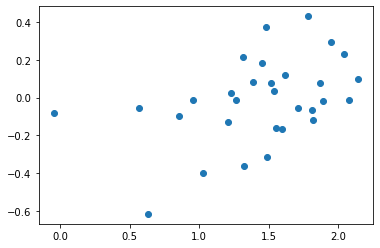

In [15]:
plt.scatter(y_mon_clm_jan[:,1], y_ann_clm[:,1])

In [51]:
# perform linear regression of annual (x-axis) vs monthly (y-axis) temps

idx_slope = np.zeros(3043)
idx_intercept = np.zeros(3043)

for i in np.arange(3043):
    idx_slope[i], idx_intercept[i], r, p, se = linregress(y_ann_clm[:,i], y_mon_clm_jan[:,i])

    
idx_slope.max()    

4.22063291877348

In [52]:
y_ma = np.zeros(idx_l.shape)
y_ma = ma.masked_array(y_ma, mask=idx_l==False)
y_ma[idx_l]=idx_slope

print(y_ma.min(), y_ma.max())

-0.4808158569665561 4.22063291877348


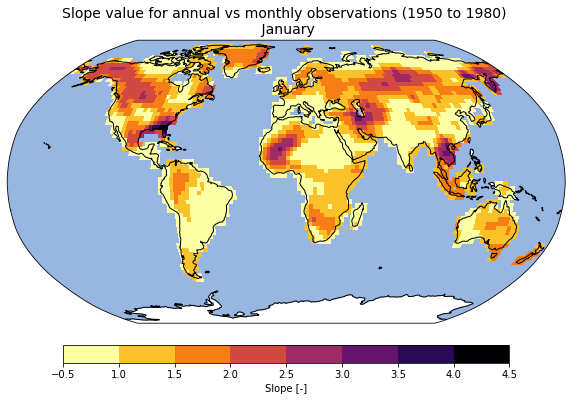

In [39]:
fig=plt.figure(figsize=(10,20))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

bounds = np.array([-0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('inferno_r')

mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma, cmap=cmap,norm=norm, transform=ccrs.PlateCarree(),rasterized=True)

ax.set_title('Slope value for annual vs monthly observations (1950 to 1980) \n January',fontsize=14)
#ax.add_feature(cfeature.OCEAN)
cbar=plt.colorbar(mesh_1,ax=[ax],orientation='horizontal',ticks=([-0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]),shrink=0.8,pad=0.02,aspect=25)
cbar.set_label('Slope [-]')  
    
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.show()

## now for July

In [53]:
## monthly data

y_mon_clm = y_all_mon[480:840] # 1950 until 1980
y_mon_clm.shape

y_mon_clm_jan = y_mon_clm[6::12]  # select the July month
y_mon_clm_jan.shape

(30, 3043)

In [54]:
## anunual data

y_ann_clm = y_all[40:70] # 1950 until 1980
y_ann_clm.shape

(30, 3043)

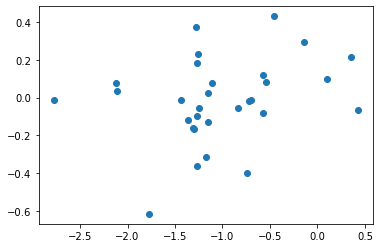

In [55]:
plt.scatter(y_mon_clm_jan[:,1], y_ann_clm[:,1])

In [1]:
# perform linear regression of annual (x-axis) vs monthly (y-axis) temps

idx_slope = np.zeros(3043)
idx_intercept = np.zeros(3043)

for i in np.arange(3043):
    idx_slope[i], idx_intercept[i], r, p, se = linregress(y_ann_clm[:,i], y_mon_clm_jan[:,i])

    
idx_slope.shape    

NameError: name 'np' is not defined

In [57]:
y_ma = np.zeros(idx_l.shape)
y_ma = ma.masked_array(y_ma, mask=idx_l==False)
y_ma[idx_l]=idx_slope

print(y_ma.min(), y_ma.max())

-0.38567300870310767 2.5904808233810637


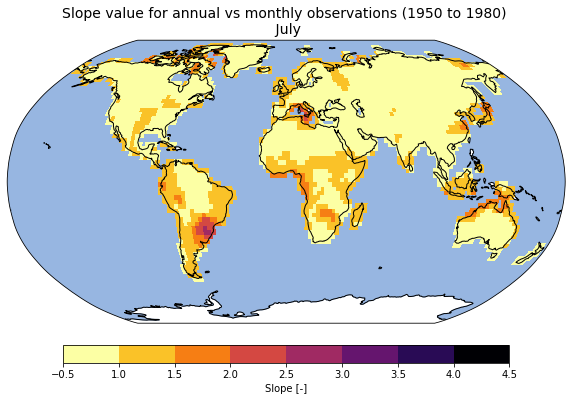

In [61]:
fig=plt.figure(figsize=(10,20))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

bounds = np.array([-0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('inferno_r')

mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma, cmap=cmap,norm=norm, transform=ccrs.PlateCarree(),rasterized=True)

ax.set_title('Slope value for annual vs monthly observations (1950 to 1980) \n July',fontsize=14)
#ax.add_feature(cfeature.OCEAN)
cbar=plt.colorbar(mesh_1,ax=[ax],orientation='horizontal',ticks=([-0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]),shrink=0.8,pad=0.02,aspect=25)
cbar.set_label('Slope [-]')  
    
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.show()